# GPT mini mini: Treinando meu primeiro transformer de Zero (Parte 1)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# TORCH MODULE
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# LOCAL MODULE
from llms.datasets.datasets import CharDataset
from llms.transformer import NeuralNetTransformer

plt.ion()   # interactive mode

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/pedrodiamel/gpt_mini_mini/blob/main/books/gpt_mini_mini_dev.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [ ]:
!nvidia-smi

In [ ]:
using_colab = False

In [ ]:
if using_colab:
    import torch
    print("PyTorch version:", torch.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    #!pip install git+https://github.com/pedrodiamel/gpt_mini_mini
    !{sys.executable} -m pip install "git+https://github.com/pedrodiamel/gpt_mini_mini"
    !mkdir -p /.datasets/llms/brasiliansong/
    !wget -P /.datasets/llms/brasiliansong/ https://raw.githubusercontent.com/pedrodiamel/gpt_mini_mini/main/data/brasiliansong/input.txt


In [4]:
DATASET_PATH = "/.datasets/llms/brasiliansong/input.txt"
MODEL_PATH = "/.models/gptcourse/gptcourse_gpt2mm_v0.04/models/chk000002.pth.tar"
NO_CUDA = False
SEED=1
GPU=0

In [3]:
with open(DATASET_PATH, "r", encoding="utf-8") as f:
    data = f.read()

In [4]:
print("quantidade de caracteres: ", len(data))

cantidade de caracteres:  8990763


In [5]:
# vamos a olhar os primeros 100 caracteres 
print(data[:500])

10 Beijos de Rua:
Acabou outra vez. 
Foi cena repetida. 
Um tchau com gosto de fica. 
Me chamaram aqui pra sair. 
Nem no clima eu to. 
Mas só de raiva eu vou. 
Meu coração nem ia. 
Mas só que a teimosia. 
Chegou em mim parou, parou. 
Na primeira boca já senti remorso. 
Beijando mal de propósito. 
Torcendo pra acabar. 
O que eu nem devia começar. 
10 de beijos de rua. 
Não valem metade do seu. 
No canto da boca. 
Imagina na boca. 
10 beijos de rua. 
Não causa efeito. 
De quando me abraça com roup


In [30]:
# aqui vamos a obtener nosso vocabulario. 
# en este caso vamos a calcular todos os caracteres presentes no nosso dataset
voc = sorted(list(set(data)))
vocab_size = len(voc)

print("".join(voc))
print(vocab_size)

	
 !"#$%&'()*+,-./0123456789:;=?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡ª°²´º¿ÀÁÂÃÇÈÉÊËÍÒÓÔÕÚßàáâãäçèéêëìíîïñòóôõöùúûüāœ​–—―‘’“”„…♪♫ﬂ﻿
160


In [31]:
# vocabulario baseado em palabras
# voc = [ w for l in data.split("\n") for w in l.split(" ") ]
# voc = sorted(list(set(voc)))
# vocab_size = len(voc)

# print(" ".join(voc))
# print(vocab_size)


In [37]:
# vamos a tokenizar nosso vocabulario 
# o que significa tokenizar? vamos a criar um lookup table dos componentes do vocabulario

# chart/word/bytes to int 
stoi = { s:i for i,s in enumerate(voc) }
# int to chart/word/bytes ....
itos = { i:s for i,s in enumerate(voc) }

encoder = lambda s: [stoi[c] for c in s] # enconder: recebe un string e retorna os tokens 
decoder = lambda t: "".join([itos[i] for i in t]) # deconder: recebe uma lista de tokens e decondifica o string 

print(encoder("Olá pessoal do cin"))
print(decoder(encoder("Olá pessoal do cin")))

[47, 75, 121, 2, 79, 68, 82, 82, 78, 64, 75, 2, 67, 78, 2, 66, 72, 77]
Olá pessoal do cin


In [ ]:
# Existem outras formas de tokenizar 
# - Google: https://github.com/google/sentencepiece 
# - OpenIA: https://github.com/openai/tiktoken


In [47]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")

print("tamanho do vocabulario: ", enc.n_vocab) 
print(enc.encode("Olá pessoal do cin"))
print(enc.decode(enc.encode("Olá pessoal do cin")))


tamanho do vocabulario:  50257
[30098, 6557, 279, 408, 78, 282, 466, 269, 259]
Olá pessoal do cin


In [2]:
# vamos a crear um dataloader para pytorch
# ver tutoria: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# other examples: https://github.com/pytorch/examples/blob/main/word_language_model/data.py

import torch
from torch.utils.data import Dataset


class Vocabulary:
    def __init__(self, data):
        
        self.voc = sorted(list(set(data)))
        self.vocab_size = len(voc)
        self.stoi = {ch: i for i, ch in enumerate(self.voc)}
        self.itos = {i: ch for i, ch in enumerate(self.voc)}

    def encoder(self, message):
        return [self.stoi[s] for s in message]

    def decoder(self, tokens):
        return "".join([self.itos[int(i)] for i in tokens])


class CharDataset(Dataset):
    
    def __init__(self, pathname, block_size, train=True, download=False):
        """CharDataset
        Args:
            pathname (str): path to dataset
            block_size (int): block size for context window
            train (bool): train or test
            download (bool): download dataset if not found
        Ref:
            https://github.com/facebookresearch/xformers/blob/main/examples/microGPT.py
        """

        if not os.path.isfile(pathname):
            raise FileNotFoundError("Dataset not found.")

        with open(pathname, "r", encoding="utf-8") as f:
            data = f.read()

        voc = sorted(list(set(data)))
        vocab_size = len(voc)

        self.stoi = {ch: i for i, ch in enumerate(voc)}
        self.itos = {i: ch for i, ch in enumerate(voc)}

        n = int(0.9 * len(data)) # 90% para train e o resto para validação
        data = data[:n] if train else data[n:]
        data_size = len(data)

        self.pathname = pathname
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
        self.count = data_size
        self.voc = voc

    def __len__(self):
        return self.count - self.block_size

    def __getitem__(self, i):
        chunk = self.data[i : i + self.block_size + 1]
        dix = [self.stoi[s] for s in chunk]

        # src and target are off by one, we want the model to predict the next word
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

    def to_tokens(self, message, device):
        return torch.tensor([self.stoi[s] for s in message], dtype=torch.long)[None, ...].to(device)

    def from_tokens(self, tokens):
        return "".join([self.itos[int(i)] for i in tokens])



In [5]:
dataset = CharDataset(DATASET_PATH, block_size=4, train=False)
print(len(dataset))

899073


In [6]:
x, y = dataset[0]
print("x: ", x, "decode: ", dataset.from_tokens(x))
print("y: ", y, "decode: ", dataset.from_tokens(y))


x:  tensor([76, 68,  2, 68]) decode:  me e
y:  tensor([68,  2, 68, 77]) decode:  e en


In [ ]:

# p(y | x,w)
# x = image_gato, y= gato
# p(y=gato | image_gato, w) = f(x)_w

# p(y=68 | 76)
# p(y=2  | 76, 68)
# p(y=68 | 76, 68, 2)
# p(y=77 | 76, 68, 2, 68) = f([x1,x2, ...xT])_w
#         ----- T ------ 


In [20]:
# creando un dataloader en pytorch para obtener os batch para o trenamento
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler

batch_size = 4
block_size = 8 # context windows 
workers = 1

# Create dataset
dataset = CharDataset(DATASET_PATH, block_size, train=False)

# Load data
dataloader = DataLoader(
    dataset,
    batch_size=4,
    sampler=RandomSampler(dataset),
    num_workers=workers,
    pin_memory=False,
    drop_last=True,
)

print(len(dataloader))
print(len(dataset)/4)


224767
224767.25


In [ ]:
# p(y | x,w)
# x = image_gato, y= gato
# p(y=gato | image_gato, w) = f(x)_w

# p(y=68 | 76)
# p(y=2  | 76, 68)
# p(y=68 | 76, 68, 2)
# p(y=77 | 76, 68, 2, 68) = f([x1,x2, ...xT])_w
#         ----- T ------ 


In [21]:
# ciclo de treinamento

# for epoch in epochs 
for x,y in dataloader:
    print("x \in ", x.shape)
    print("y \in ", y.shape)

    # yh = f(x)_w = [yh]_(B,T,Cv) (*) Attention 
    # J = CE(y, yh)

    # pytorch opt
    # W^(t+1) = W^t - lr*grad(J) (1)
    # opt.zero_grad()
    # J.backward() => grad(J)
    # opt.step()
    
    break



x \in  torch.Size([4, 8])
y \in  torch.Size([4, 8])


In [23]:
# implementando meu primero transformer 
import torch
import torch.nn as nn
from torch.nn import functional as F

class GPTmm(nn.Module):

    # # step 1
    # def __init__(self, vocab_size):
    #     super().__init__()
    #     self.emb = nn.Embedding(vocab_size, vocab_size) # [emb]_(Cv, k)
    

    # def forward(self, x):
    #     # in: [x]_(B,T)
    #     # out: [yh]_(B,T,Cv)

    #     yh = self.emb(x)
    #     return yh

    # #step 2
    # def __init__(self, vocab_size):
    #     super().__init__()

    #     n_embd = 4
    #     self.emb_x = nn.Embedding(vocab_size, n_embd) # [emb]_(Cv, C)
    #     self.emb_pe = nn.Embedding(block_size, n_embd) # [emb]_(T, C) # learning positional enconding 
    #     self.linear = nn.Linear(n_embd, vocab_size)

    # def forward(self, x):
    #     # in: [x]_(B,T)
    #     # out: [yh]_(B,T,Cv)
    #     B,T = x.shape
        
    #     # positional encoding 
    #     x_emb = self.emb_x(x)
    #     pe_emb = self.emb_pe(torch.arange(T))
    #     x = x_emb + pe_emb # [x]_(B,T,C)
        
    #     yh = self.linear(x) # [x*W]_(B,T,Cv)
    #     return yh


    def __init__(self, vocab_size, block_size):
        super().__init__()

        n_embd = 4
        head_size = 6 #d_k
        
        self.emb_x = nn.Embedding(vocab_size, n_embd) # [emb]_(Cv, C)
        self.emb_pe = nn.Embedding(block_size, n_embd) # [emb]_(T, C) # learning positional enconding 

        self.key = nn.Linear(n_embd, head_size, bias=False) # X*W_k
        self.query = nn.Linear(n_embd, head_size, bias=False) # X*W_q
        self.value = nn.Linear(n_embd, head_size, bias=False) # X*W_v

        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)))

        # no final
        self.linear = nn.Linear(head_size, vocab_size)

    def forward(self, x):
        # in: [x]_(B,T)
        # out: [yh]_(B,T,Cv)
        B,T = x.shape
        
        # positional encoding 
        x_emb = self.emb_x(x)
        pe_emb = self.emb_pe(torch.arange(T))
        x = x_emb + pe_emb # [x]_(B,T,C)
        B,T,C = x.shape
            
        # ????

        k = self.key(x) # [k]_(B,T,H)
        q = self.query(x) # [q]_(B,T,H)
        v = self.value(x) # [v]_(B,T,H)
                
        #mask = torch.tril(torch.ones(T,T))
        #att = torch.zeros((T,T))
        att = q @ k.transpose(-2, -1) * C**-0.5 # [att]_(B,T,T) = [q]_(B,T,H) * [k]_(B,H,T)
        att = att.masked_fill(self.mask[:T, :T] == 0, float("-inf"))  # [att]_(B,T,T)
        att = F.softmax(att, dim=-1)  # [att]_(B,T,T)
            
        x = att @ v # [att]_(B,T,T) * [v]_(B,T,H) => [x]_(B,T,H)
                
        yh = self.linear(x) # [x*W]_(B,T,Cv)
        return yh
    
vocab_size = dataset.vocab_size
f = GPTmm(vocab_size, block_size)
yh = f(x)
print(yh.shape)



torch.Size([4, 8, 160])


In [24]:
# definir um optimizador
# vamos empregar adamw
opt = torch.optim.AdamW(f.parameters(), lr=1e-3)

In [30]:

def train(max_iter=100):

    Js = []
    f.train()
    for i,(x,y) in enumerate(dataloader):
        # yh = f(x)_w = [yh]_(B,T,Cv) (*) Attention 
        # J = CE(y, yh)
    
        yh = f(x)
        J = F.cross_entropy(yh.view(-1, vocab_size), y.view(-1))
    
        # pytorch opt
        # W^(t+1) = W^t - lr*grad(J) (1)
        # opt.zero_grad()
        # J.backward() => grad(J)
        # opt.step()
    
        opt.zero_grad(set_to_none=True)
        J.backward()
        opt.step()

        Js.append(J.item())
        
        if i % 1000 == 0:
            print(J.item()) 

        if i > max_iter:
            break

    return Js


epochs = 1
for epoch in range(epochs):
    print("Epoch ", epoch)
    Js = train(max_iter=3500)


Epoch  0
2.9682085514068604
3.4441325664520264
2.7077553272247314
2.8119888305664062


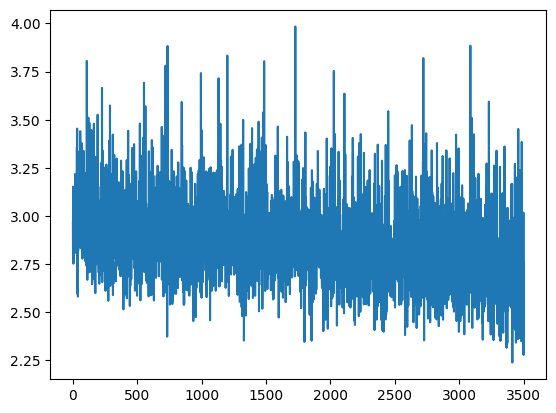

In [31]:
plt.figure()
plt.plot(Js)
plt.show()

In [ ]:
# Positional Encoding 
# https://kazemnejad.com/blog/transformer_architecture_positional_encoding

# [x]_(B,T)
# [emb_x]_(B,T,C)
# [pe]_(T,C)
#
# PE(pos, 2i) = sin(pos/1000^(2i)/C) // pos \in [0,T)
# PE(pos, 2i+1) = cos(pos/1000^(2i)/C)


In [8]:
import math 

B, T, C = 4,3,4

x = torch.zeros(B,T,C) # [x]_(B,T,C)
pe = torch.zeros((T, C))
pos = torch.arange(0, T).unsqueeze(1)
div_term = torch.exp(torch.arange(0, C, 2).float() * (-math.log(10000.0) / C))

print(pe.shape)
print(pos)

pe[:, 0::2] = np.sin(pos*div_term)
# pe[:, 1::2] = np.cos(pos*div_term)

print(pe)

x_pe = x + pe
print(x_pe.shape)
print(x_pe[1,...])


torch.Size([3, 4])
tensor([[0],
        [1],
        [2]])
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.8415, 0.0000, 0.0100, 0.0000],
        [0.9093, 0.0000, 0.0200, 0.0000]])
torch.Size([4, 3, 4])
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.8415, 0.0000, 0.0100, 0.0000],
        [0.9093, 0.0000, 0.0200, 0.0000]])


In [34]:
# geração de texto empregando o modelo 
# xT+1 = arg max p(y | x1,x2, ... xT, w)
# xT+2 = arg max p(y | x2,x3, ... xT+1, w)
# ...
# xT+M = arg max p(y | xM-T,x3, ... xM, w)

def generate(f, x, max_tokens):
    # f: modelo treinado f(x)_w
    # x: contexto [x]_(B,T)
    # max_tokens: maximos tokens gerados  
    #
    f.eval()
    for i in range(max_tokens):
        x_ = x if x.size(1) <= block_size else x[:,-block_size:]
        y = f(x_) # [y]_(B=1,T,Cv)
        y = y[:,-1,...]

        # calcular a probabilidade
        p = F.softmax(y, dim=-1)

        # estimar o proximo token 
        # xt = torch.argmax(p, dim=-1, keepdim=True)
        xt = torch.multinomial(p, num_samples=1)

        x = torch.cat((x,xt), dim=1) # [x]_(B,T+1) 

        # imprimir os resultados 
        print("{}".format( dataset.from_tokens(x[0]) ))
   
    return x 

context = "Estou rodando um exemplo"
x = dataset.to_tokens(context, torch.device("cpu") )
tokens = generate(f, x, 10)
# print(tokens)

# p = p.detach().cpu().numpy()[0,...]
# print(p.shape)

# plt.figure()
# plt.plot(p)
# plt.show()

10 Beijos de.
10 Beijos de. 
10 Beijos de. Q
10 Beijos de. Qs
10 Beijos de. Qs 
10 Beijos de. Qs C
10 Beijos de. Qs Co
10 Beijos de. Qs Com
10 Beijos de. Qs Come
10 Beijos de. Qs Comer


In [17]:
# As matematicas das camadas self-attention
from torch.nn import functional as F

torch.manual_seed(1337)
B,T,C = 4,4,6 # batch, time, channels
x = torch.randint(10,(T,C)) * 1.0
print(x)
print(x.shape)

# Step 1
# mascara de attention
# att = torch.tril(torch.ones(T,T))
# att = att / att.sum(dim=1, keepdim=True)
# print(att)
# y = att @ x
# print(y)

# Step 2
# attention
mask = torch.tril(torch.ones(T,T))
att = torch.zeros((T,T))
att = att.masked_fill(mask[:T, :T] == 0, float("-inf"))  # [att]_(B,T,T)
att = F.softmax(att, dim=-1)  # [att]_(B,T,T)

print(att)

y = att @ x
print(y)
print(y.shape)


# mask é constante (T,T)
# att (T,T) => (B,T,T) ?????
# x (T,C) => (B,T,C)
# y (T,C) => (B,T,C)

tensor([[5., 7., 2., 0., 5., 3.],
        [5., 0., 4., 0., 2., 0.],
        [7., 6., 0., 8., 1., 4.],
        [9., 5., 3., 6., 2., 0.]])
torch.Size([4, 6])
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500]])
tensor([[5.0000, 7.0000, 2.0000, 0.0000, 5.0000, 3.0000],
        [5.0000, 3.5000, 3.0000, 0.0000, 3.5000, 1.5000],
        [5.6667, 4.3333, 2.0000, 2.6667, 2.6667, 2.3333],
        [6.5000, 4.5000, 2.2500, 3.5000, 2.5000, 1.7500]])
torch.Size([4, 6])
